In [1]:
# Import the required libraries
import warnings
import scipy.io as io
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # Matlab-style plotting
plt.rcParams['font.sans-serif']=['Simhei'] 
plt.rcParams['axes.unicode_minus']=False   
import seaborn as sns
from sklearn.model_selection import train_test_split
import math
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from keras.utils import np_utils#one-hot
import tensorflow as tf
from scipy.linalg import orth
from scipy.linalg import svd
from scipy.special import softmax
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
# Import data sets
X=io.loadmat(r'./Dataset/norbX.mat')
y=io.loadmat(r'./Dataset/norbnumY.mat')

In [3]:
y=pd.DataFrame(y['norbnumY'])

In [4]:
X=pd.DataFrame(X['norbX'])

In [5]:
# View dataset information
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2048 entries, 0 to 2047
Columns: 48600 entries, 0 to 48599
dtypes: uint8(48600)
memory usage: 94.9 MB


In [6]:
y.T.value_counts()

5    9720
4    9720
3    9720
2    9720
1    9720
dtype: int64

In [7]:
print("data shpe: {}; label shape: {}".format(X.shape, y.shape))
# data:d*n
#label:m*n
#n is the number of sample

data shpe: (2048, 48600); label shape: (1, 48600)


In [8]:
# normalisation
scaler = MinMaxScaler(feature_range=(0, 1))  
# X= scaler.fit_transform(X)

zscore=StandardScaler()
X=zscore.fit_transform(X)

In [9]:
X_train = X.T[:24300,:]
X_test = X.T[-24300:,:]
y_train = y.T.head(24300)
y_test = y.T.tail(24300)

In [10]:
# Hyperparameter definitions
MAX_LAYER = 1
MAX_SUBNET = 14
# TRAING_RATIO = 0.7
SAMPLE_RATIO=0.6
HiddernNeuronsNum=3500
lamb=1e-7
para = 0.05
actFun = 'gelu'
p = 0.9
nl=0.0001
randomProES = 0.99#probability to early stop
randomProSN = 0.6#probability of stopping add subnetwork

In [11]:
X_train.shape

(24300, 2048)

In [12]:
y_train.shape

(24300, 1)

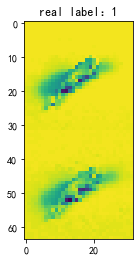

In [13]:
# plt.imshow(X_train.iloc[0].values.reshape(64,32))
plt.imshow(X_train[0].reshape(64,32))
plt.title('real label：'+str(y_train.iloc[0][0]))
plt.show()

In [14]:
#Transform labels from training and test sets into one-hot
y_train = y_train - 1
y_test = y_test - 1
y_train = np_utils.to_categorical(y_train,5)
y_test = np_utils.to_categorical(y_test,5)

In [15]:
#View the first ten training set labels
y_train[:10]

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [16]:
# Auto-encoder based on pseudo-inverse learning
def PILAE(X,p,actFun,para):
    #X:num*dim
    lambda0 = 1e-8
    N = X.shape[0]
    d = X.shape[1]
    WI = (np.random.rand(p,d)*2-1)
    if p >= d:
        WI = orth(WI)
    else:
        WI = orth(WI.T).T
    H = WI.dot(X.T)
    HO = ActivationFunc(H,actFun,1)
#     print('X.T:{}'.format(X.T.shape))
#     print('HO:{}'.format(HO.shape))
    WO = X.T.dot(np.transpose(HO)).dot(np.linalg.pinv( HO.dot(np.transpose(HO))+lambda0*np.identity(p)))
    F = np.transpose(WO).dot(X.T)
    F = ActivationFunc(F,actFun,para)


    return WI,WO,F

In [17]:
def ActivationFunc(tempH,ActivationFunction,p):
    
    if ActivationFunction == 'relu':
        H=np.maximum(0,tempH)
    elif ActivationFunction == 'prelu':
        alpha = 0.02;

        H=np.maximum(alpha*tempH,tempH)
    elif ActivationFunction == 'gelu':#xσ(1.702x)
        H = tempH * 1.0/ (1 + np.exp(-p*tempH*1.702))
    elif ActivationFunction == 'sigmod':
        H = 1.0/(1+np.exp(-tempH))
    elif ActivationFunction == 'srelu':
        tempH[tempH <= 0] = 0
        tempH[tempH > 0] = tempH
        H = tempH
    elif ActivationFunction == 'sin':
        H = np.sin(tempH)
    elif ActivationFunction == 'tanh':
        H = np.np.tanh(tempH)
    return H

In [18]:
X_train32 = X_train.reshape(24300,64,32)

In [19]:
X_train32.shape

(24300, 64, 32)

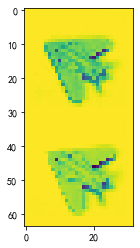

In [20]:
plt.imshow(X_train32[2])

In [21]:
#Dimensionality reduction or prediction on the receptive field data
def SONG_PRF_reduc_pred(newmap, method, net,testF,BiasofHiddenNeurons):
    if method ==1:
        # #################### reduction #####################
        InputDataLayer = newmap
        l=1
        while l<=1:
            tF = net['WO'][l-1].T.dot(InputDataLayer.T)
            tF = ActivationFunc(tF,actFun,2)
            InputDataLayer = tF
            l = l+1
            if len(testF) == 0:
                testF.append(InputDataLayer)
                testF = testF[0]
            else:
                testF = np.vstack((testF,InputDataLayer))
    elif method == 2:
        # #################### prediction #####################
        H = np.dot(net['WI'][0], newmap.T)
        ind = np.ones((1, newmap.shape[0]), dtype=int)
        BiasMatrix=np.dot(BiasofHiddenNeurons,ind)
        H = H + BiasMatrix
        HO = ActivationFunc(H,actFun,para)
        TO = np.dot(net['WO'][0], HO)
        if len(testF) == 0:
            testF.append(TO)
            testF = testF[0]

        else:
            testF = np.vstack((testF,TO))

    return testF

In [22]:
def SONG_PRF(X, Y, TX,ValidData,VaT, winSize, stride, dim,w,h,noiseLevel,actFun,para,lam):
    #X:num*dim
    #Y:num*classNum
    GRID = 8
    numdims=X.shape[1]
    numsamples=X.shape[0]
    HiddernNeuronsNum = winSize*4
    NumberOfTestSamples = TX.shape[0]
    NumberOfValidSamples = ValidData.shape[0]
 
    trainF = []
    validF = []
    testF = []
    label_index = [(np.argmax(one_hot)+1)for one_hot in np.array(Y)]
    label_indexArr = np.array(label_index)
    if (dim==2):
        X=X.reshape(numsamples,h,w)
        ValidData=ValidData.reshape(NumberOfValidSamples,h,w)
        TX=TX.reshape(NumberOfTestSamples,h,w)
        newY = np.zeros((Y.shape[0],GRID,Y.shape[1]*GRID))
        for j in range(1,GRID+1):
            for i in range(1,Y.shape[0]+1):
                new_label_index = (label_indexArr-1)*GRID+1
                newY[i-1,j-1,new_label_index[i-1]+j-1-1] = 1
        start_idx=0
        stop = 0
        hstart_idx=0
        hstop = 0
        while (not stop):
            if (start_idx+winSize-1 >= w-1):
                end_idx  = w-1
                stop = 1
            else:
                end_idx = start_idx+winSize-1
            length = end_idx - start_idx+1
            hstart_idx=0
            hstop = 0
            while (not hstop):
                if (hstart_idx+winSize >= h):
                    hend_idx  = h-1
                    hstop = 1
                else:
                    hend_idx = hstart_idx+winSize-1
                hlen = hend_idx - hstart_idx+1
                win = X[:,hstart_idx:hend_idx+1,start_idx:end_idx+1]
                if stop == 1 and hstop==1:
                    win = np.concatenate((win,np.zeros((X.shape[0],winSize-win.shape[1],length))),axis=1)
                    #break
                if stop == 0 and hstop == 1:
                    win = np.concatenate((win,np.zeros((X.shape[0],winSize-win.shape[1],winSize))),axis=1)

                if start_idx<=math.ceil(w/2) and hstart_idx<=math.ceil(h/4):#upper left
                    extY = np.reshape(newY[:,0,:],(Y.shape[0],Y.shape[1]*GRID))
                elif start_idx>math.ceil(w/2) and hstart_idx<=math.ceil(h/4):#upper right
                    extY = np.reshape(newY[:,1,:],(Y.shape[0],Y.shape[1]*GRID))
                elif start_idx<=math.ceil(w/2)and hstart_idx>math.ceil(h/4) and hstart_idx<=math.ceil(h/2):
                    extY = np.reshape(newY[:,2,:],(Y.shape[0],Y.shape[1]*GRID))
                elif start_idx>math.ceil(w/2) and hstart_idx>math.ceil(h/4) and hstart_idx<=math.ceil(h/2):
                    extY = np.reshape(newY[:,3,:],(Y.shape[0],Y.shape[1]*GRID))
                elif start_idx<=math.ceil(w/2)and hstart_idx>math.ceil(h/2) and hstart_idx<=math.ceil(h*3/4):
                    extY = np.reshape(newY[:,4,:],(Y.shape[0],Y.shape[1]*GRID))
                elif start_idx>math.ceil(w/2) and hstart_idx>math.ceil(h/2) and hstart_idx<=math.ceil(h*3/4):
                    extY = np.reshape(newY[:,5,:],(Y.shape[0],Y.shape[1]*GRID))
                elif start_idx<=math.ceil(w/2)and hstart_idx>math.ceil(h*3/4):#lower left
                    extY = np.reshape(newY[:,6,:],(Y.shape[0],Y.shape[1]*GRID))
                elif start_idx>math.ceil(w/2) and hstart_idx>math.ceil(h*3/4):#lower right
                    extY = np.reshape(newY[:,7,:],(Y.shape[0],Y.shape[1]*GRID))
                # ####################training########################
                win = np.reshape(win,(numsamples,length*winSize))
#                 newmap= scaler.fit_transform(win)
                newmap=zscore.fit_transform(win)
                method = 1
                net={}
                net['WI'] = []
                net['WO'] = []
                if method ==1:
                    # #################### reduction #####################
                    l=1
                    BiasofHiddenNeurons=0
                    while l<=1:
                        InputDataLayer = newmap

                        WI,WO,F = PILAE(InputDataLayer,HiddernNeuronsNum,actFun,2)
                        net['WI'].append(WI)
                        net['WO'].append(WO)
                        InputDataLayer = F
                        l = l+1

                    if len(trainF) == 0:
                        trainF.append(InputDataLayer)
                        trainF = trainF[0]

                    else:
                        trainF = np.vstack((trainF,InputDataLayer))

                elif method == 2:
                    # #################### prediction #####################
                    InputWeight = np.random.rand(HiddernNeuronsNum, length * winSize) * 2 - 1
                    BiasofHiddenNeurons = np.random.rand(HiddernNeuronsNum, 1)
                    H = np.dot(InputWeight, newmap.T)
                    ind = np.ones((1, numsamples), dtype=int)

                    BiasMatrix=np.dot(BiasofHiddenNeurons,ind)
                    H = H + BiasMatrix
                    HO = ActivationFunc(H, actFun, para)
                    OutputWeight = extY.T.dot(HO.T).dot(np.linalg.pinv(np.dot(HO, HO.T) + lamb * np.eye(HiddernNeuronsNum)))
                    O = np.dot(OutputWeight, HO)
                    net['WI'].append(InputWeight)
                    net['WO'].append(OutputWeight)
                    if len(trainF) == 0:
                        trainF.append(O)
                        trainF = trainF[0]

                    else:
                        trainF = np.vstack((trainF,O))
                # #################### validating ########################
                win = ValidData[:,hstart_idx:hend_idx+1,start_idx:end_idx+1]
                if stop == 1 and hstop==1:
                    win = np.concatenate((win,np.zeros((ValidData.shape[0],winSize-win.shape[1],length))),axis=1)
                    #break
                if stop == 0 and hstop == 1:

                    win = np.concatenate((win,np.zeros((ValidData.shape[0],winSize-win.shape[1],winSize))),axis=1)
                win = np.reshape(win,(NumberOfValidSamples,length*winSize))

#                 newmap= scaler.fit_transform(win)
                newmap=zscore.fit_transform(win)
                validF = SONG_PRF_reduc_pred(newmap, method, net,validF,BiasofHiddenNeurons)

                # #################### testing ########################
                
                win = TX[:,hstart_idx:hend_idx+1,start_idx:end_idx+1]
                if stop == 1 and hstop==1:
                    win = np.concatenate((win,np.zeros((TX.shape[0],winSize-win.shape[1],length))),axis=1)
                    #break
                if stop == 0 and hstop == 1:
                    win = np.concatenate((win,np.zeros((TX.shape[0],winSize-win.shape[1],winSize))),axis=1)
                win = np.reshape(win,(NumberOfTestSamples,length*winSize))

#                 newmap= scaler.fit_transform(win)
                newmap=zscore.fit_transform(win)
                testF = SONG_PRF_reduc_pred(newmap, method, net,testF,BiasofHiddenNeurons)

                hstart_idx = hend_idx+1
            start_idx = end_idx+1
        newmap=None
        win=None
        
        if method==2:
            HiddernNeuronsNum = y_test.shape[1]*GRID

        return HiddernNeuronsNum,trainF,validF,testF
    elif dim==1:
        GRID=2
        HiddernNeuronsNum = 128
        newY = np.zeros((Y.shape[0],GRID,Y.shape[1]*GRID))
        for j in range(1,GRID+1):
            for i in range(1,Y.shape[0]+1):
                new_label_index = (label_indexArr-1)*GRID+1
                newY[i-1,j-1,new_label_index[i-1]+j-1-1] = 1
        start_idx=1
        stop = 0
        while (not stop):
            if (start_idx+winSize-1 >= w-1):
                end_idx  = w-1
                stop = 1
            else:
                end_idx = start_idx+winSize-1
            length = end_idx - start_idx+1
            win = X[:,start_idx:end_idx+1]
            if stop == 1:
                win = np.concatenate((win,np.zeros((X.shape[0],winSize-win.shape[1]))),axis=1)
            if start_idx<=math.ceil(w/2):# left
                extY = np.reshape(newY[:,0,:],(Y.shape[0],Y.shape[1]*GRID))
            elif start_idx>math.ceil(w/2):# right
                extY = np.reshape(newY[:,1,:],(Y.shape[0],Y.shape[1]*GRID))
            newmap=zscore.fit_transform(win)
            method = 1
            net={}
            net['WI'] = []
            net['WO'] = []
            if method ==1:
                # #################### reduction #####################
                l=1
                BiasofHiddenNeurons=0
                while l<=1:
                    InputDataLayer = newmap
                    WI,WO,F = PILAE(InputDataLayer,HiddernNeuronsNum,actFun,2)
                    net['WI'].append(WI)
                    net['WO'].append(WO)
                    InputDataLayer = F
                    l = l+1

                if len(trainF) == 0:
                    trainF.append(InputDataLayer)
                    trainF = trainF[0]
                else:
                    trainF = np.vstack((trainF,InputDataLayer))
            elif method == 2:
                # #################### prediction #####################
                InputWeight = np.random.rand(HiddernNeuronsNum, length * winSize) * 2 - 1
                BiasofHiddenNeurons = np.random.rand(HiddernNeuronsNum, 1)
                H = np.dot(InputWeight, newmap.T)
                ind = np.ones((1, numsamples), dtype=int)
                BiasMatrix=np.dot(BiasofHiddenNeurons,ind)
                H = H + BiasMatrix
                HO = ActivationFunc(H, actFun, para)
                OutputWeight = extY.T.dot(HO.T).dot(np.linalg.pinv(np.dot(HO, HO.T) + lamb * np.eye(HiddernNeuronsNum)))
                O = np.dot(OutputWeight, HO)
                net['WI'].append(InputWeight)
                net['WO'].append(OutputWeight)
                if len(trainF) == 0:
                    trainF.append(O)
                    trainF = trainF[0]
                else:
                    trainF = np.vstack((trainF,O))
            # #################### validating ########################
            win = ValidData[:,start_idx:end_idx+1]
            if stop == 1:
                win = np.concatenate((win,np.zeros((ValidData.shape[0],winSize-win.shape[1]))),axis=1)
                #break
               
            newmap=zscore.fit_transform(win)
            validF = SONG_PRF_reduc_pred(newmap, method, net,validF,BiasofHiddenNeurons)
            # #################### testing ########################
                
            win = TX[:,start_idx:end_idx+1]
            if stop == 1:
                win = np.concatenate((win,np.zeros((TX.shape[0],winSize-win.shape[1]))),axis=1)
                #break

            newmap=zscore.fit_transform(win)
            testF = SONG_PRF_reduc_pred(newmap, method, net,testF,BiasofHiddenNeurons)
            start_idx = end_idx+1
        newmap=None
        win=None
        
        if method==2:
            HiddernNeuronsNum = y_test.shape[1]*GRID
        return HiddernNeuronsNum,trainF,validF,testF

In [23]:
def SONG_self_atten(train,valid,test,patch_len):
    #train:number of training sample*dim
    #valid:num*dim
    #test:num*dim
    train_sample_num = train.shape[0]
    test_sample_num = test.shape[0]
    valid_sample_num= valid.shape[0]
    patch_num = math.ceil(train.shape[1]/patch_len)


    tr = []
    te = []
    va = []
    shape = np.ones((patch_len,1))
    for train_sample_idx in range(1,train_sample_num+1):
        tr_sample = []

        X = np.reshape(train[train_sample_idx-1,:],(patch_len,patch_num))
        K = X
        Q = X.T

        M = Q.dot(K)/math.sqrt(K.shape[0])
        A = softmax(M.T, axis=0)
        for patch_idx in range(1,patch_num+1):
            Att=np.kron(A[:,patch_idx-1].T,shape)
            Z = X*Att
            S=np.sum(Z, axis=1)
            tr_sample.extend(S)
        tr.append(tr_sample)
    tr = np.array(tr)
    
    for valid_sample_idx in range(1,valid_sample_num+1):
        va_sample = []
        X = np.reshape(valid[valid_sample_idx-1,:],(patch_len,patch_num))
        K = X
        Q = X.T
        M = Q.dot(K)/math.sqrt(K.shape[0])
        A = softmax(M.T, axis=0)
        for patch_idx in range(1,patch_num+1):
            Att=np.kron(A[:,patch_idx-1].T,shape)
            Z = X*Att
            S=np.sum(Z, axis=1)
            va_sample.extend(S)
        va.append(va_sample)
    va = np.array(va)
    
    for test_sample_idx in range(1,test_sample_num+1):
        te_sample = []
        X = np.reshape(test[test_sample_idx-1,:],(patch_len,patch_num))
        K = X
        Q = X.T
        M = Q.dot(K)/math.sqrt(K.shape[0])
        A = softmax(M.T, axis=0)
        for patch_idx in range(1,patch_num+1):
            Att=np.kron(A[:,patch_idx-1].T,shape)
            Z = X*Att
            S=np.sum(Z, axis=1)
            te_sample.extend(S)
        te.append(te_sample)
    te = np.array(te)
    return tr,va,te

In [24]:
def SONG_Test_Classifier(data,y,esbTY,InputWeight,OutputWeight,BiasofHiddenNeurons,para,actFun):
    #data:dim*num
    #y:num*classnum
    InputDataLayer = data
    InputLabel = y
    NumberOfTestSamples = InputDataLayer.shape[1]
    y_test_label = [np.argmax(one_hot)for one_hot in np.array(y)]
    tempH=InputWeight.dot(InputDataLayer)
    InputDataLayer= None
    ind=np.ones((1,NumberOfTestSamples))
    BiasMatrix=np.dot(BiasofHiddenNeurons,ind)
    tempH=tempH+BiasMatrix
    HO = ActivationFunc(tempH,actFun,para)
    TY=OutputWeight.dot(HO)
    
    a = np.argmax(TY.T, axis=1)
    b = np.zeros((len(a), TY.shape[0]))
    b[np.arange(len(a)), a] = 1
    pred = [np.argmax(one_hot)for one_hot in np.array(b)]
    Tacc = accuracy_score(y_test_label,pred)
    esbTY = esbTY + TY.T
    a = np.argmax(esbTY, axis=1)
    b = np.zeros((len(a), esbTY.shape[1]))
    b[np.arange(len(a)), a] = 1
    pred = [np.argmax(one_hot)for one_hot in np.array(b)]

    Eacc = accuracy_score(y_test_label,pred)
    return pred,Eacc,esbTY

In [25]:
### SONG
sub_net = 1
best_V_Eacc = 0
X_trainO = X_train
y_trainO = y_train

X_train, X_valid, y_train, y_valid = train_test_split(X_trainO, y_trainO, test_size = 0.2)
esbTY = np.zeros(y_test.shape)
esbVY = np.zeros(y_valid.shape)

while (sub_net <= MAX_SUBNET):
    SR=np.random.normal(loc=SAMPLE_RATIO,scale=0.02)
    if SR > 1 or SR <=0:
        SR = SAMPLE_RATIO
    X_train, X_va, y_train, y_va = train_test_split(X_trainO, y_trainO, test_size = 1-SR)
    y_train_label = [np.argmax(one_hot)for one_hot in np.array(y_train)]
    patch=np.random.randint(4,8)/3.5
    PRFWinSize = math.ceil(32/patch)
    stride = math.ceil(PRFWinSize/1)

    hsize,trainBatch,validBatch,testBatch = SONG_PRF(X_train,y_train,X_test,X_valid,y_valid,PRFWinSize,stride,2,64,32,nl,actFun,para,lamb)
    if trainBatch.shape[0]==0:
        print('no suitable bcatch')
        continue
    trainBatch,validBatch,testBatch = SONG_self_atten(trainBatch.T,validBatch.T,testBatch.T,hsize)#dim*num

    trainBatch= scaler.fit_transform(trainBatch)
    validBatch= scaler.fit_transform(validBatch)
    testBatch= scaler.fit_transform(testBatch)
#     trainBatch=zscore.fit_transform(trainBatch)
#     validBatch = zscore.fit_transform(validBatch)
#     testBatch=zscore.fit_transform(testBatch)

    #==================================
    l=1
    InputDataLayer = trainBatch
    best_V_acc = 0
    net={}
    net['WI']=[]
    net['WO']=[]
    best_V_acc = 0
    TInputDataLayer=[]
    cls = {}
    cls['Bias'] = []
    cls['IW'] = []
    cls['OW'] = []
    while l<=MAX_LAYER:
        WI,WO,F = PILAE(InputDataLayer,math.floor(p*InputDataLayer.shape[1]),actFun,2)
        net['WO'].append(WO)
        InputDataLayer = F
        TInputDataLayer.append(InputDataLayer)

        numsamples = InputDataLayer.shape[1]
        numdims = InputDataLayer.shape[0]
        InputWeight=np.random.rand(HiddernNeuronsNum,numdims)*2-1
        if HiddernNeuronsNum >= numdims:
            InputWeight = orth(InputWeight)
        else:
            InputWeight = orth(InputWeight.T).T
        BiasofHiddenNeurons=np.random.rand(HiddernNeuronsNum,1)
        cls['Bias'].append(BiasofHiddenNeurons)
        tempH=InputWeight.dot(InputDataLayer)
        cls['IW'].append(InputWeight)
        ind=np.ones((1,numsamples))
        BiasMatrix=np.dot(BiasofHiddenNeurons,ind)
        tempH=tempH+BiasMatrix
        HO = ActivationFunc(tempH,actFun,para)
        OutputWeight=np.transpose(y_train).dot(np.transpose(HO)).dot(np.linalg.pinv( HO.dot(np.transpose(HO))+lamb*np.identity(HiddernNeuronsNum)))
        Y=OutputWeight.dot(HO)
        cls['OW'].append(OutputWeight)
        H0=None
        tempH=None
        a = np.argmax(Y.T, axis=1)
        b = np.zeros((len(a), Y.shape[0]))
        b[np.arange(len(a)), a] = 1
        pred = [np.argmax(one_hot)for one_hot in np.array(b)]
        acc = accuracy_score(y_train_label,pred)
        l = l+1

    InputDataLayer = validBatch
    l=1
    while l<=MAX_LAYER:
        vF = net['WO'][l-1].T.dot(InputDataLayer.T)
        vF = ActivationFunc(vF,actFun,2)
        InputDataLayer = vF
        VY=0
        pred,Vacc,VY = SONG_Test_Classifier(InputDataLayer,y_valid,VY,cls['IW'][l-1],cls['OW'][l-1],cls['Bias'][l-1],para,actFun)
        #print('子网Vacc:{}'.format(Vacc))
        if Vacc >= best_V_acc:
            best_V_acc = Vacc
            validBatch = InputDataLayer
            MAX_LAYER2 = MAX_LAYER
        else:
            if np.random.rand() < randomProES:
                MAX_LAYER2 = l-1
                break
        
        l=l+1

    InputDataLayer = testBatch
    l=1
    while l<=MAX_LAYER2:
        tF = net['WO'][l-1].T.dot(InputDataLayer.T)
        tF = ActivationFunc(tF,actFun,2)
        InputDataLayer = tF
        l=l+1
    testBatch = InputDataLayer

    pred,VEacc,esbVY = SONG_Test_Classifier(validBatch,y_valid,esbVY,cls['IW'][MAX_LAYER2-1],cls['OW'][MAX_LAYER2-1],cls['Bias'][MAX_LAYER2-1],para,actFun)
    #print('子网络数:{},VEacc:{}'.format(sub_net,VEacc))
    if VEacc >= best_V_Eacc:
        best_V_Eacc = VEacc
    else:
        if np.random.rand() < randomProSN:
            sub_net += 1
        break
        
    #test
    VTpred,Eacc,esbTY = SONG_Test_Classifier(testBatch,y_test,esbTY,cls['IW'][MAX_LAYER2-1],cls['OW'][MAX_LAYER2-1],cls['Bias'][MAX_LAYER2-1],para,actFun)

    if (sub_net % 3)==0:
        print('subnets:{},acc:{}'.format(sub_net,Eacc))
    sub_net = sub_net + 1

subnets:3,acc:0.8933333333333333
subnets:6,acc:0.9125102880658437
subnets:9,acc:0.9165432098765433
subnets:12,acc:0.9204938271604939


In [26]:
print('subnets:{},acc:{}'.format(sub_net-1,Eacc))

subnets:14,acc:0.9209876543209876


In [27]:
#pred
y_test_label = [np.argmax(one_hot)for one_hot in np.array(y_test)]

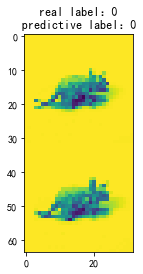

In [28]:
i = 0
#绘制图像

img_test = X_test[i].reshape(64,32)
plt.imshow(img_test)


title='real label：{}\npredictive label：{}'.format(y_test_label[i],VTpred[i])

plt.title(title)
plt.show()

In [29]:
from sklearn.metrics import confusion_matrix 
confusion_matrix(y_test_label,VTpred)

array([[4588,  136,  109,   18,    9],
       [ 429, 4302,   67,    2,   60],
       [ 157,   26, 4555,   20,  102],
       [  41,   12,   12, 4720,   75],
       [  10,    0,    3,  632, 4215]], dtype=int64)